# Examining Concentrated Liquidity Techniques

## Goals
- Understand the value of re-balancing
    - Explore both "chasing" and Geometric Mean rebalancing
- Look at tight ranges and re-balancing vs larger ranges
- Need to understand both bull and bear cases

### Each frame relies on data from a previous one, so make sure all frames have been run

### First step is to get historical data to use for price predictions

In [1]:
# Module imports
import helper_classes as hc
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# Keep the historical fetching below 90 days to get hourly based data
api_id = 'bitcoin'
end = pd.Timestamp(dt.today())
start = end - pd.DateOffset(days=80)  # Get previous years worth of data
btc_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

api_id = 'ethereum'
end = pd.Timestamp(dt.today())
start = end - pd.DateOffset(days=80)  # Get previous years worth of data
eth_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

api_id = 'solana'
end = pd.Timestamp(dt.today())
start = end - pd.DateOffset(days=80)  # Get previous years worth of data
sol_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

Getting historical in_data for bitcoin
Try #1
Getting historical in_data for ethereum
Try #1
Getting historical in_data for solana
Try #1


### Create a prediction model using the Weiner process
- Start with Bitcoin
- Can use the historical price chart to decide how much data you want to include to determine the mean and variance used in the model
    - 30 days is what we'll start with

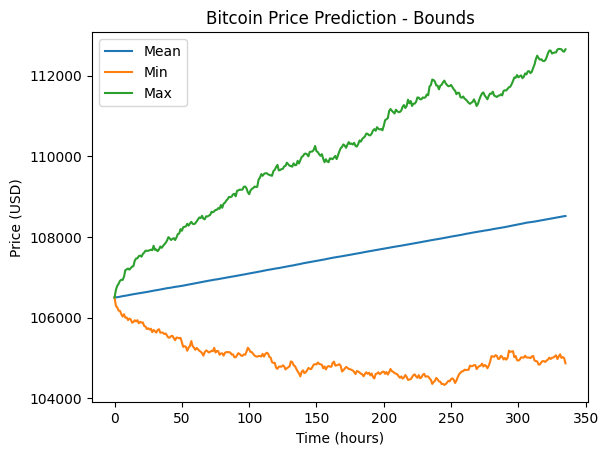

In [3]:
# Use Weiner process to get future price predictions
lookback_days = 7  # Decide how much historical data to use for prediciton input
lookback_hours = lookback_days * 24
data = btc_data.copy().tail(lookback_hours)
data['gain'] = data['price'].pct_change()
mean_gain = data['gain'].mean()
var_multiplier = 1.2  # use this to get a wider range of outcomes
std_gain = data['gain'].std() * var_multiplier

btc = hc.Token("BTC", 106500)
iterations = 2500  # Can adjust this for more variance if desired
predict_days = 14
predict_hours = predict_days * 24
b = hc.Brownian()
predict = []
for i in range(iterations):
    x = b.stock_price(btc.price, mean_gain, std_gain, predict_hours, 1)
    predict.append(x)
df = pd.DataFrame(predict).T

# Look at price prediction over time
mean_price = df.mean(axis=1)
min_price = df.min(axis=1)
max_price = df.max(axis=1)
std_price = df.std(axis=1)

plt.plot(df.index, mean_price, label='Mean')
plt.plot(df.index, min_price, label='Min')
plt.plot(df.index, max_price, label='Max')
plt.title('Bitcoin Price Prediction - Bounds')
plt.xlabel('Time (hours)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

<Axes: title={'center': 'Bitcoin Price Prediction Simulations'}, xlabel='Hours', ylabel='Price(USD)'>

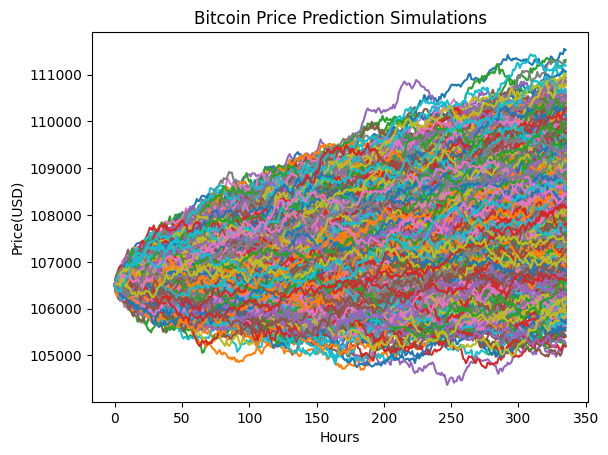

In [23]:
df.plot(legend=False, ylabel='Price(USD)', xlabel='Hours',title='Bitcoin Price Prediction Simulations')

### Next we need to set up our starting conditions for our investment and understand the potential fees earned
- Fees need to be taken from the LP in use, such as Aerodrome, Uniswap, or PancakeSwap

Fee per hour, per liquidity tick: $132.13
Fee per hour: $26.43


<Axes: >

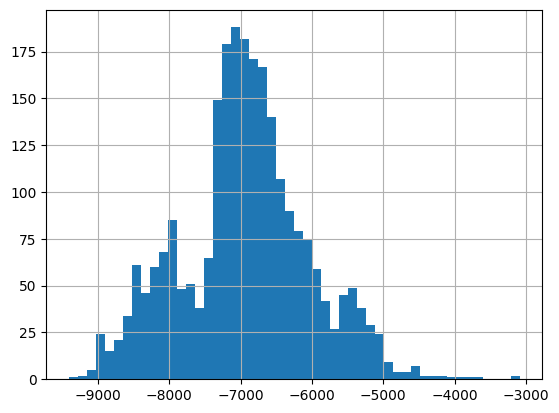

In [4]:
# cbBTC/USDC Farm stats on Aerodrome
tick_spacing = 100
weekly_rewards = 400652
tvl_rewarded = 1.8E6  # This can change quite a bit and determines how "concentrated" the pool is
apr_per_tick = weekly_rewards / tvl_rewarded * 52 * 100
seed = 100000
fee_per_hour_per_tick = apr_per_tick / 100 / 365 / 24 * seed
print(f"Fee per hour, per liquidity tick: ${fee_per_hour_per_tick:.2f}")

# Decide on ranges to use.  
high_pct = 2
low_pct = 2
# Convert to ticks based on spacing
high_tick = int(high_pct * tick_spacing / 100)
low_tick = int(low_pct * tick_spacing / 100)
fee_per_hour = fee_per_hour_per_tick / (high_tick + low_tick + 1)
print(f"Fee per hour: ${fee_per_hour:.2f}")

# print(df.iloc[:,20])
# Setup initial position
# print(btc_usdc)

il = []
rebalance = True
for label, sim in df.items():  # Each column is a simulation
    # Set up LP
    btc = hc.Token("BTC", 106500)
    usdc = hc.Token("USDC", 1)
    btc_usdc = hc.LiquidityPool(btc, usdc)
    btc_usdc.gm_rebalance = False
    btc_usdc.setup_new_position(seed, low_tick, high_tick)
    for price in sim.iloc[1:].values:  # start after the first hour
        btc.price = price
        btc_usdc.update_token_balances(1/24)
        if btc_usdc.in_range:
            btc_usdc.fees_accrued += fee_per_hour * 0.982  # VFAT charges 1.8% fee on AERO rewards
        elif rebalance:
            btc_usdc.rebalance(low_tick, high_tick)
        else:
            pass
    il.append(btc_usdc.impermanent_loss)
loss = pd.Series(il)
loss.hist(bins=50)


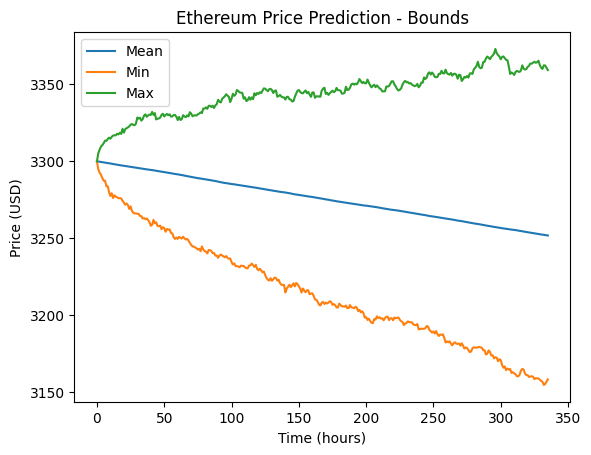

In [5]:
# Ethereum
# Use Weiner process to get future price predictions
lookback_days = 30  # Decide how much historical data to use for prediciton input
lookback_hours = lookback_days * 24
data = eth_data.copy().tail(lookback_hours)
data['gain'] = data['price'].pct_change()
mean_gain = data['gain'].mean()
var_multiplier = 1.2  # use this to get a wider range of outcomes
std_gain = data['gain'].std() * var_multiplier

start_price = 3300
iterations = 2500  # Can adjust this for more variance if desired
predict_days = 14
predict_hours = predict_days * 24
b = hc.Brownian()
predict = []
for i in range(iterations):
    x = b.stock_price(start_price, mean_gain, std_gain, predict_hours, 1)
    predict.append(x)
df = pd.DataFrame(predict).T

# Look at price prediction over time
mean_price = df.mean(axis=1)
min_price = df.min(axis=1)
max_price = df.max(axis=1)
std_price = df.std(axis=1)

plt.plot(df.index, mean_price, label='Mean')
plt.plot(df.index, min_price, label='Min')
plt.plot(df.index, max_price, label='Max')
plt.title('Ethereum Price Prediction - Bounds')
plt.xlabel('Time (hours)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Fee per hour, per liquidity tick: $129.49
Fee per hour: $18.50


<Axes: >

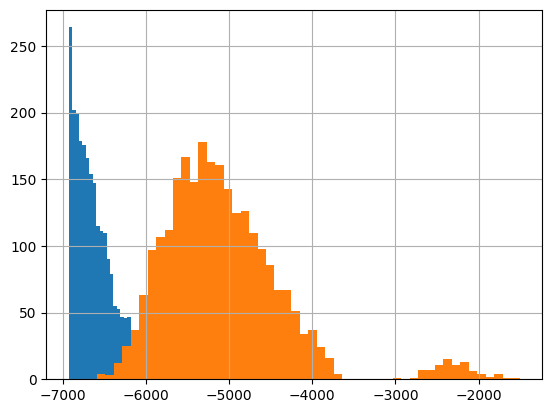

In [12]:
# WETH/USDC Farm stats on Aerodrome
tick_spacing = 100
weekly_rewards = 1308872
tvl_rewarded = 6E6  # This can change quite a bit and determines how "concentrated" the pool is
apr_per_tick = weekly_rewards / tvl_rewarded * 52 * 100
seed = 100000
fee_per_hour_per_tick = apr_per_tick / 100 / 365 / 24 * seed
print(f"Fee per hour, per liquidity tick: ${fee_per_hour_per_tick:.2f}")

# Decide on ranges to use.  
high_pct = 3
low_pct = 3
# Convert to ticks based on spacing
high_tick = int(high_pct * tick_spacing / 100)
low_tick = int(low_pct * tick_spacing / 100)
fee_per_hour = fee_per_hour_per_tick / (high_tick + low_tick + 1)
print(f"Fee per hour: ${fee_per_hour:.2f}")

il = []
val = []
rebalance = True
for label, sim in df.items():  # Each column is a simulation
    # Set up LP
    eth = hc.Token("ETH", 3300)
    usdc = hc.Token("USDC", 1)
    eth_usdc = hc.LiquidityPool(eth, usdc)
    eth_usdc.gm_rebalance = True
    eth_usdc.setup_new_position(seed, low_tick, high_tick)
    for price in sim.iloc[1:].values:  # start after the first hour
        eth.price = price
        eth_usdc.update_token_balances(1/24)
        if eth_usdc.in_range:
            eth_usdc.fees_accrued += fee_per_hour * 0.982  # VFAT charges 1.8% fee on AERO rewards
        elif rebalance:
            eth_usdc.rebalance(low_tick, high_tick)
        else:
            pass
    il.append(eth_usdc.impermanent_loss)
    val.append(seed - eth_usdc.value)
loss = pd.Series(il)
loss.hist(bins=50)
final_value = pd.Series(val)
final_value.hist(bins=50)